In [2]:
# Ngan
# Importing necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import json
from PIL import Image

In [3]:
#Import thử thoi đừng chạy nha (hân)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import shutil
import os
import pandas as pd

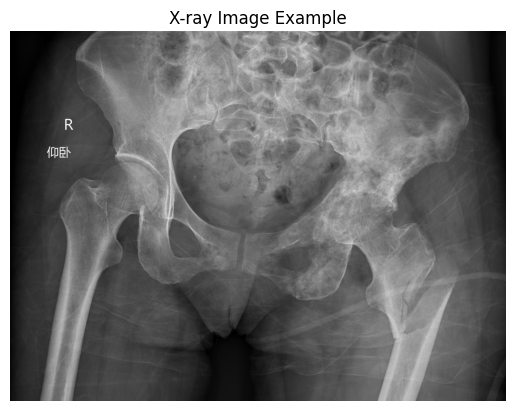

In [4]:
# Ngan
# đọc 1 ảnh
import cv2
import matplotlib.pyplot as plt

# Đường dẫn tới hình ảnh trong thư mục dataset
image_path = '/kaggle/input/btxrd-data/BTXRD/BTXRD/images/IMG000001.jpeg'

# Đọc hình ảnh bằng OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Hiển thị hình ảnh bằng Matplotlib
plt.imshow(image, cmap='gray')
plt.title('X-ray Image Example')
plt.axis('off')
plt.show()


# **Dùng EDA** 

In [5]:
# Ngan
# Đọc dữ liệu 5 tệp JSON đầu tiên để kiểm tra thông tin annotation

annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'

json_files = [f for f in os.listdir(annotation_dir) if f.endswith(".json")]

# Đọc dữ liệu từ 5 file JSON đầu tiên
annotations = []
for json_file in json_files[:5]: 
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        annotations.append(data)

# Chuyển dữ liệu JSON thành DataFrame
df = pd.json_normalize(annotations)
print(df.head())



  version                                             shapes       imagePath  \
0   5.4.1  [{'label': 'multiple osteochondromas', 'points...  IMG000966.jpeg   
1   5.4.1  [{'label': 'other bt', 'points': [[102.9999999...  IMG001116.jpeg   
2   5.4.1  [{'label': 'giant cell tumor', 'points': [[261...  IMG000811.jpeg   
3   5.4.1  [{'label': 'osteochondroma', 'points': [[737.3...  IMG000486.jpeg   
4   5.4.1  [{'label': 'multiple osteochondromas', 'points...  IMG000397.jpeg   

  imageData  imageHeight  imageWidth  
0      None         2345        1168  
1      None         2773        2306  
2      None          770         535  
3      None         2240        1845  
4      None         1258         539  


In [6]:
# Han
# đọc 5 dòng đầu file excel 
path = "/kaggle/input/btxrd-data/BTXRD/BTXRD/"
df = pd.read_excel(path+"dataset.xlsx", engine="openpyxl")
print(df)

# trong file excel bao gồm thông tin của ảnh, bệnh nhân, 
# vị trí xương, thông tin về khối u (có khối u không, lành tính hay ác tính)
# hệ xương phụ (Appendicular Skeleton gồm xương chi trên, chi dưới và xương chậu)
# và hướng chụp

            image_id  center  age gender  hand  ulna  radius  humerus  foot  \
0     IMG000001.jpeg       1   48      F     0     0       0        0     0   
1     IMG000002.jpeg       1   12      M     0     0       0        0     0   
2     IMG000003.jpeg       1   12      M     0     0       0        0     0   
3     IMG000004.jpeg       1   52      M     0     0       0        0     1   
4     IMG000005.jpeg       1   52      M     0     0       0        0     1   
...              ...     ...  ...    ...   ...   ...     ...      ...   ...   
3741   IMG003742.jpg       3   55      M     0     0       0        0     0   
3742   IMG003743.jpg       3   55      M     0     0       0        0     0   
3743   IMG003744.jpg       3   55      M     0     0       0        0     0   
3744   IMG003745.jpg       3    8      M     0     0       0        0     0   
3745   IMG003746.jpg       3    8      M     0     0       0        0     0   

      tibia  ...  synovial osteochondroma  other bt

In [44]:
# Han
# hiển thị một số cột trong file dataset
print(df[[ 'image_id','center','age','gender','neoplasm' ]])

            image_id  center  age gender   neoplasm
0     IMG000001.jpeg       1   48      F  malignant
1     IMG000002.jpeg       1   12      M  malignant
2     IMG000003.jpeg       1   12      M  malignant
3     IMG000004.jpeg       1   52      M  malignant
4     IMG000005.jpeg       1   52      M  malignant
...              ...     ...  ...    ...        ...
3741   IMG003742.jpg       3   55      M   no tumor
3742   IMG003743.jpg       3   55      M   no tumor
3743   IMG003744.jpg       3   55      M   no tumor
3744   IMG003745.jpg       3    8      M   no tumor
3745   IMG003746.jpg       3    8      M   no tumor

[3746 rows x 5 columns]


In [8]:
# Ngan
# Kiểm tra số lượng ảnh có trong dataset
import os
import json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # Thêm tqdm để hiển thị tiến độ
import matplotlib.pyplot as plt

# Thư mục chứa dữ liệu
image_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/images'
annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'

# Kích thước ảnh chuẩn hóa
IMG_SIZE = 224

# Tạo danh sách lưu dữ liệu và nhãn
images = []
labels = []

# Duyệt qua các file JSON và đọc ảnh, nhãn với thanh tiến trình
for json_file in tqdm(os.listdir(annotation_dir), desc="Đang xử lý ảnh", unit="ảnh"):
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        
        # Lấy đường dẫn ảnh tương ứng
        image_filename = data['imagePath']
        image_path = os.path.join(image_dir, image_filename)
        
        # Đọc và tiền xử lý ảnh
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = image / 255.0  # Chuẩn hóa ảnh
            images.append(image)
            
            # Lấy nhãn từ file JSON
            if 'shapes' in data and len(data['shapes']) > 0:
                label = data['shapes'][0]['label']
                labels.append(label)

# Chuyển đổi dữ liệu về numpy array
images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
labels = np.array(labels)

# Kiểm tra số lượng ảnh và nhãn
print(f'\nTổng số ảnh: {len(images)}, Tổng số nhãn: {len(labels)}')


Đang xử lý ảnh: 100%|██████████| 1867/1867 [00:56<00:00, 32.76ảnh/s]



Tổng số ảnh: 1867, Tổng số nhãn: 1867


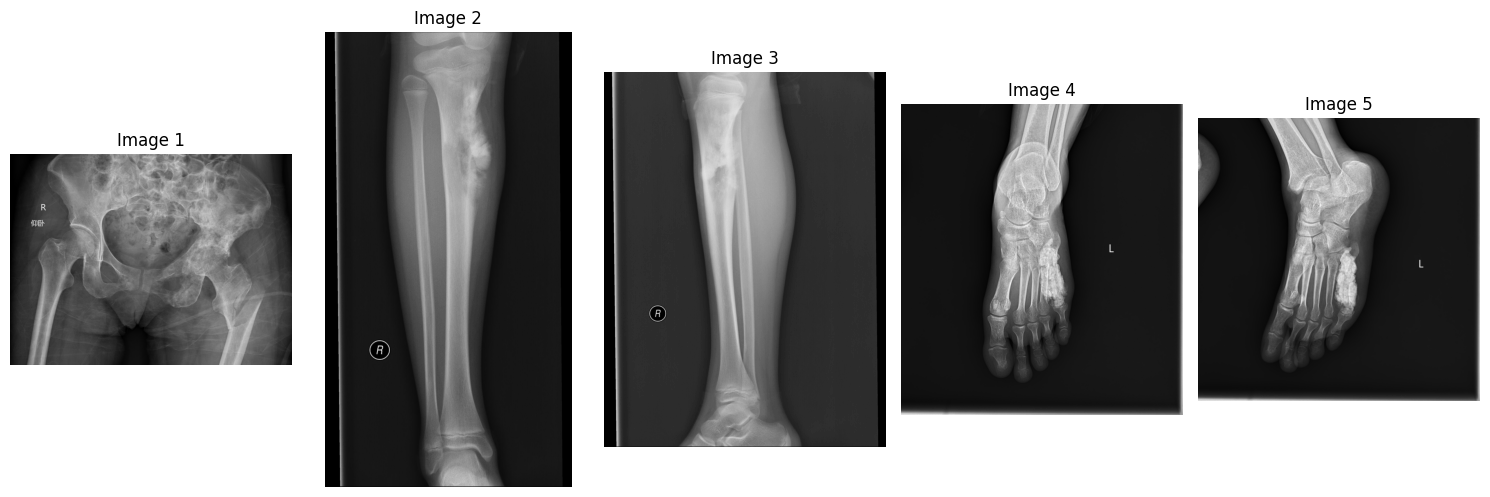

In [11]:
# Ngan
# Đọc và hiển thị 5 hình ảnh đầu tiên
import os
import cv2
import matplotlib.pyplot as plt

# Thư mục chứa hình ảnh
image_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/images'

# Lấy danh sách file ảnh hợp lệ
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Kiểm tra nếu thư mục không có ảnh
if len(image_files) == 0:
    print("Không tìm thấy ảnh trong thư mục!")
else:
    # Đọc và hiển thị 5 hình ảnh đầu tiên
    plt.figure(figsize=(15, 5))

    for i, image_file in enumerate(image_files[:5]):  
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:  # Kiểm tra ảnh có đọc được không
            plt.subplot(1, 5, i+1)
            plt.imshow(image, cmap='gray')
            plt.title(f'Image {i+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()



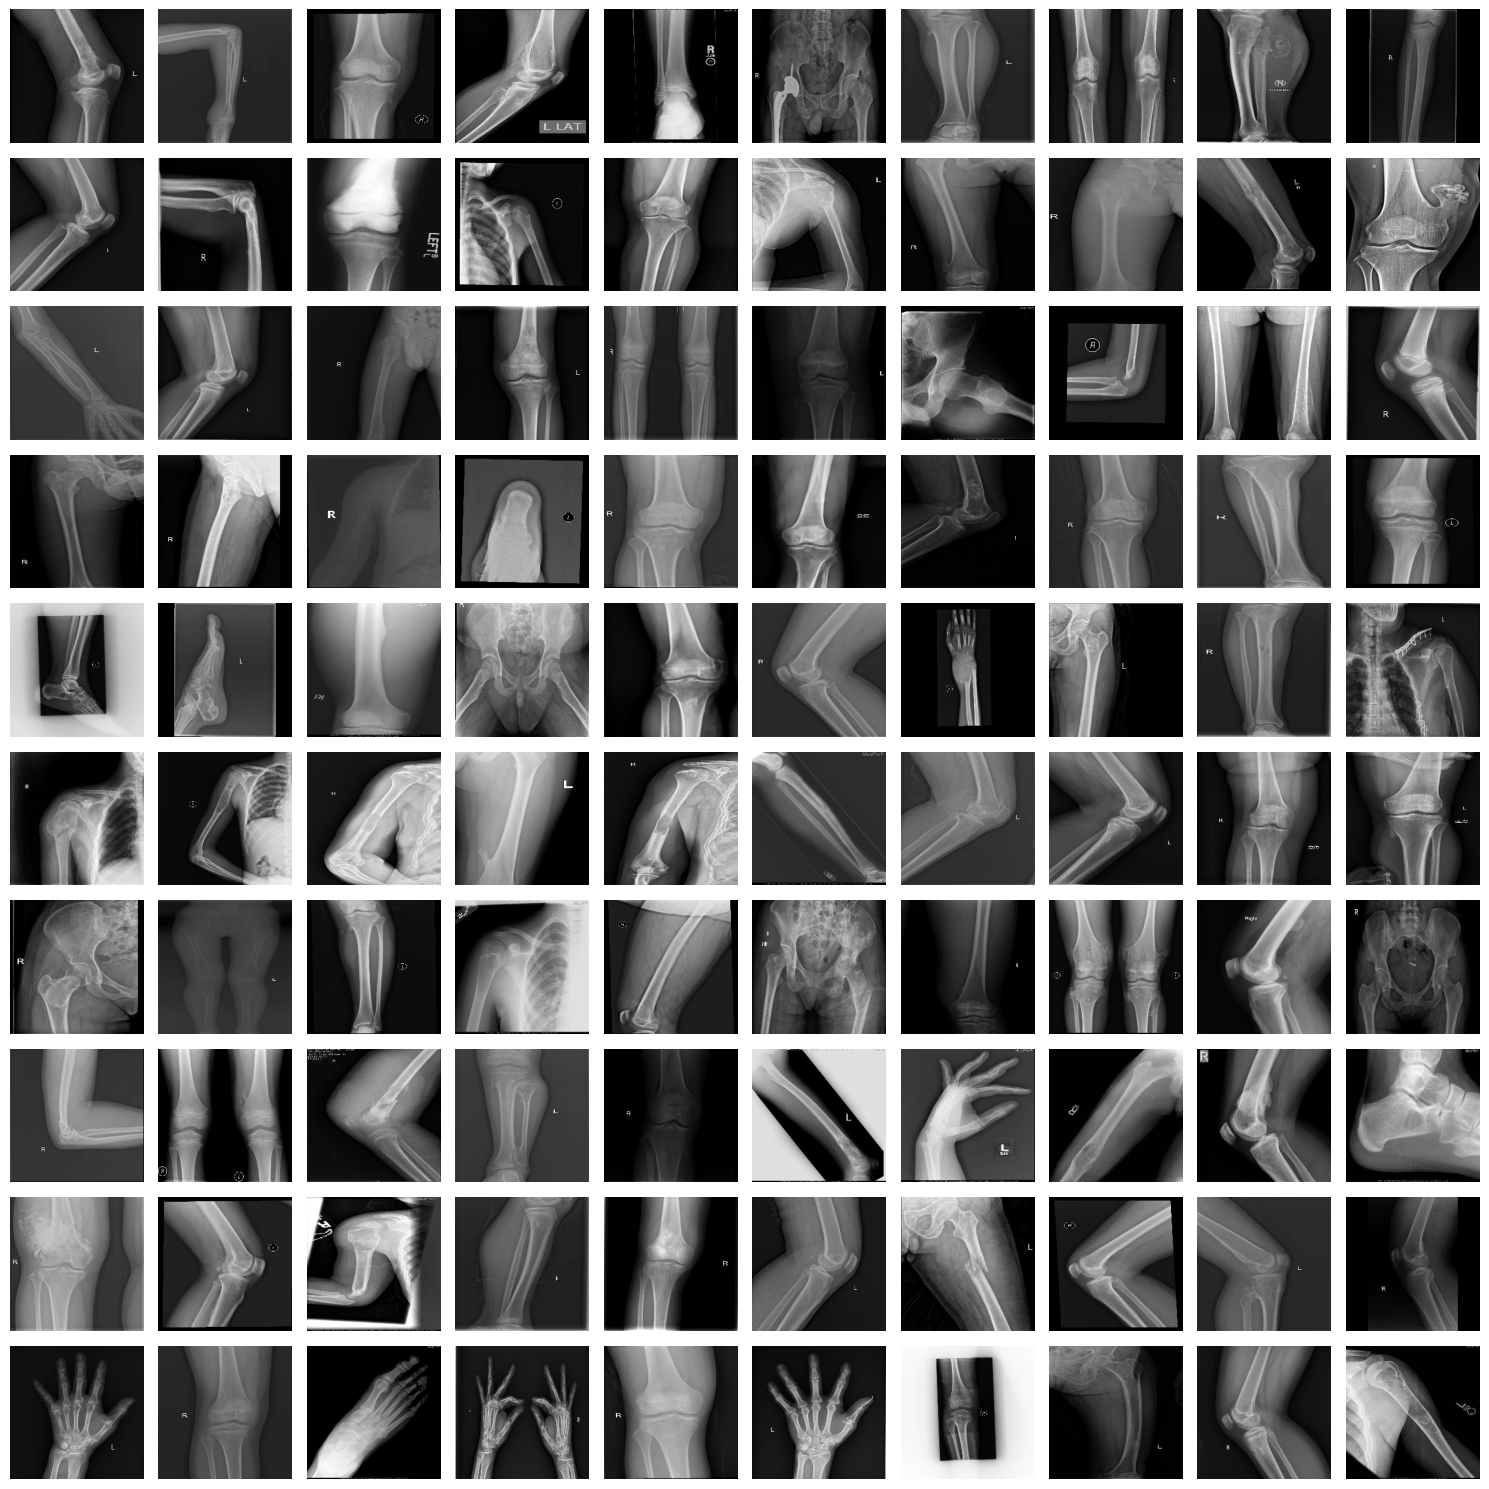

In [12]:
# Ngan
# ramdom 100 ảnh 
import random

num_images = 100

# Chọn ngẫu nhiên 100 ảnh và nhãn tương ứng
random_indices = random.sample(range(len(images)), min(num_images, len(images)))
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]

# Định dạng lưới hiển thị
rows = 10
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(random_images):
        break
    ax.imshow(random_images[i].squeeze(), cmap='gray')  # Hiển thị ảnh
    # ax.set_title(random_labels[i])  # Hiển thị nhãn ảnh
    ax.axis('off')  # Ẩn trục tọa độ

plt.tight_layout()
plt.show()


100%|██████████| 1867/1867 [00:27<00:00, 66.70it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075:

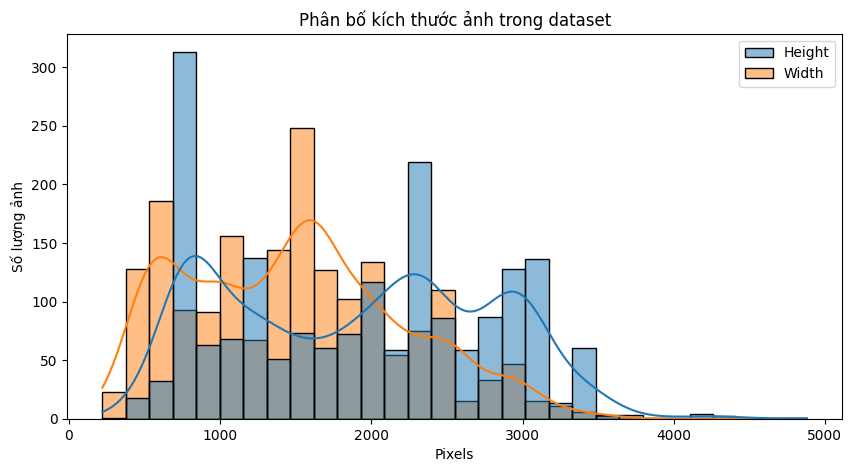

In [13]:
# Ngan
# thống kê kích thước ảnh

# Lấy danh sách kích thước ảnh (width, height)
image_sizes = [cv2.imread(os.path.join(image_dir, data['imagePath'])).shape[:2] for data in tqdm([json.load(open(os.path.join(annotation_dir, f))) for f in os.listdir(annotation_dir)])]

# Chuyển đổi về numpy array
image_sizes = np.array(image_sizes)

# Tạo DataFrame để vẽ biểu đồ
df_sizes = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

# Vẽ biểu đồ kích thước ảnh
plt.figure(figsize=(10, 5))
sns.histplot(df_sizes, kde=True, bins=30)

# Thêm nhãn và tiêu đề
plt.xlabel("Pixels")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bố kích thước ảnh trong dataset")

# Hiển thị biểu đồ
plt.show()


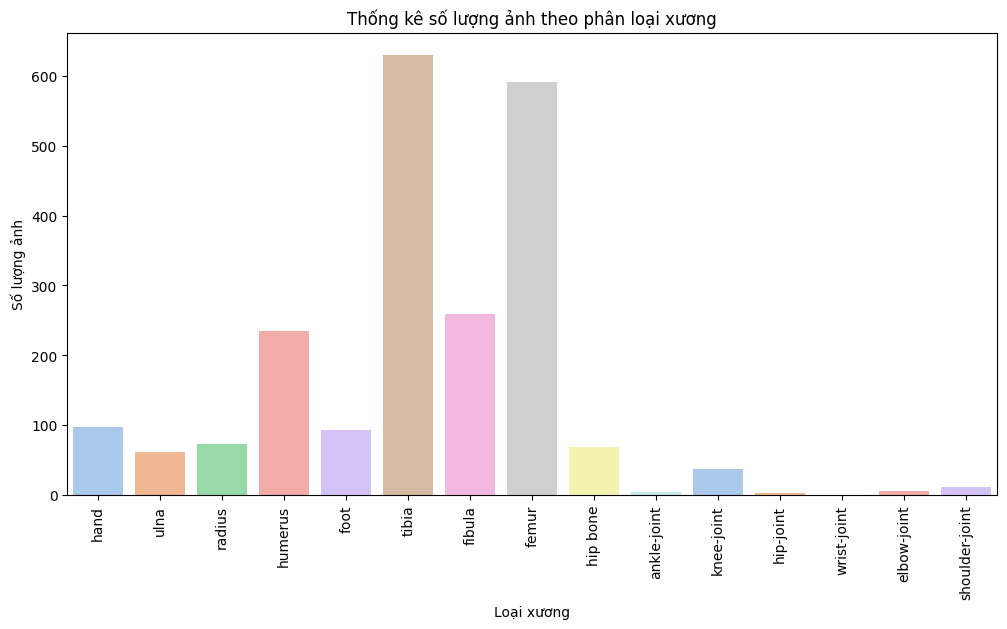

In [14]:
# Ngan
# thống kê số lượng ảnh theo phân loại xương

excel_path = "/kaggle/input/btxrd-data/BTXRD/BTXRD/dataset.xlsx"
df = pd.read_excel(excel_path)

# Danh sách các phân loại xương
bone_categories = ["hand", "ulna", "radius", "humerus", "foot", "tibia", "fibula", 
                   "femur", "hip bone", "ankle-joint", "knee-joint", "hip-joint", 
                   "wrist-joint", "elbow-joint", "shoulder-joint"]

# Đếm số lượng ảnh theo từng phân loại xương
bone_counts = df[bone_categories].sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=bone_counts.index, y=bone_counts.values, palette="pastel")
plt.xticks(rotation=90)
plt.xlabel("Loại xương")
plt.ylabel("Số lượng ảnh")
plt.title("Thống kê số lượng ảnh theo phân loại xương")
plt.show()



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


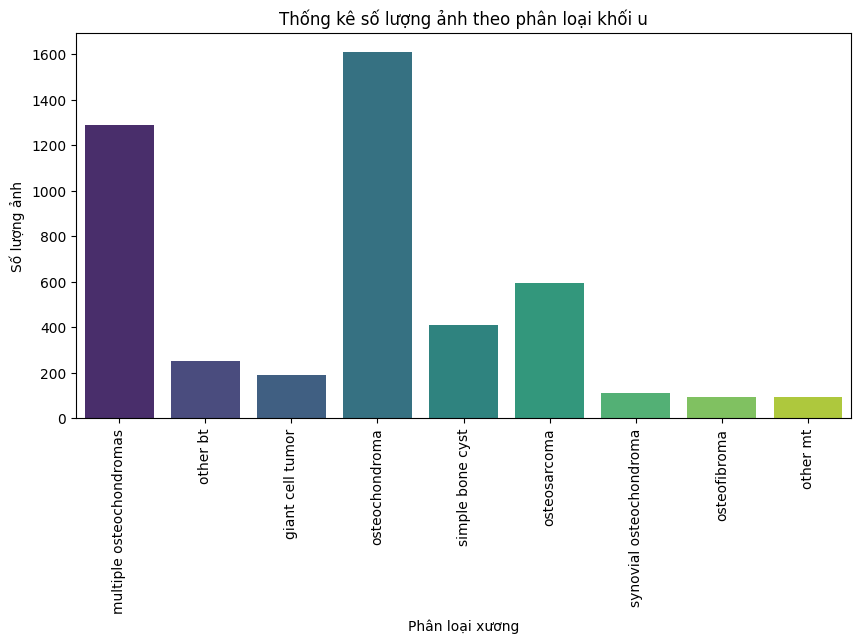

In [17]:
# Ngan
# thống kê số lượng ảnh theo phân loại khối u

from collections import Counter

annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'

# Đọc tất cả các file JSON và lấy nhãn xương
bone_labels = []

for json_file in os.listdir(annotation_dir):
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        labels = [shape["label"] for shape in data["shapes"]]
        bone_labels.extend(labels)

# Đếm số lượng từng loại xương
label_counts = Counter(bone_labels)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.xlabel("Phân loại xương")
plt.ylabel("Số lượng ảnh")
plt.title("Thống kê số lượng ảnh theo phân loại khối u")
plt.xticks(rotation=90)
plt.show()



In [23]:
# Ngan
# tạo file excel thống kê slg bone_categories và tumor_categories

# Đọc file dataset.xlsx
file_path = "/kaggle/input/btxrd-data/BTXRD/BTXRD/dataset.xlsx"
df = pd.read_excel(file_path)

# Danh sách phân loại xương (hàng)
bone_categories = ["hand", "ulna", "radius", "humerus", "foot", "tibia", "fibula", 
                   "femur", "hip bone", "ankle-joint", "knee-joint", "hip-joint", 
                   "wrist-joint", "elbow-joint", "shoulder-joint"]

# Danh sách phân loại khối u (cột)
tumor_categories = ["osteochondroma", "multiple osteochondromas", "simple bone cyst", 
                    "giant cell tumor", "osteofibroma", "synovial osteochondroma", 
                    "other bt", "osteosarcoma", "other mt"]

# Tạo DataFrame chứa số lượng ảnh theo từng loại xương và khối u
tumor_bone_counts = pd.DataFrame(0, index=bone_categories, columns=tumor_categories)

# Duyệt qua từng hàng trong DataFrame để cập nhật số lượng
for _, row in df.iterrows():
    for bone in bone_categories:
        if bone in df.columns and row[bone] == 1:  # Nếu loại xương này xuất hiện trong ảnh
            for tumor in tumor_categories:
                if tumor in df.columns and row[tumor] == 1:  # Nếu loại khối u này xuất hiện
                    tumor_bone_counts.loc[bone, tumor] += 1

# Lưu kết quả vào tệp Excel
output_excel_path = "/kaggle/working/tumor_bone_statistics.xlsx"
tumor_bone_counts.to_excel(output_excel_path)

print(f"Tệp Excel đã được tạo: {output_excel_path}")


Tệp Excel đã được tạo: /kaggle/working/tumor_bone_statistics.xlsx


In [28]:
# Ngan
# tải file
FileLink("./tumor_bone_statistics.xlsx")


/kaggle/working/tumor_bone_statistics.xlsx

In [25]:
file_path = "/kaggle/input/btxrd-data/tumor_bone_statistics.xlsx"

# Đọc dữ liệu từ sheet 'tumor_categories'
df_tumor_categories = pd.read_excel(file_path, sheet_name="tumor_bone_statistics")

# In toàn bộ dữ liệu ra màn hình
print(df_tumor_categories)

        Unnamed: 0  osteochondroma  multiple osteochondromas  \
0             hand              43                         4   
1             ulna              16                        29   
2           radius              16                        30   
3          humerus              55                        27   
4             foot              33                         8   
5            tibia             334                       152   
6           fibula              79                       140   
7            femur             164                       143   
8         hip bone              16                        14   
9      ankle-joint               0                         0   
10      knee-joint               1                         0   
11       hip-joint               0                         0   
12     wrist-joint               0                         0   
13     elbow-joint               0                         0   
14  shoulder-joint               5      

In [45]:
# Ngan
# thống kê số lượng ảnh thuộc giai đoạn ung thư nào (khối u, lành tính, ác tính)
import pandas as pd
import shutil

# Đường dẫn gốc của file (read-only)
statistical_path = "/kaggle/input/btxrd-data/tumor_bone_statistics.xlsx"

# Đường dẫn sao chép file sang thư mục làm việc (có thể ghi)
working_path = "/kaggle/working/tumor_bone_statistics.xlsx"
shutil.copy(statistical_path, working_path)  # Sao chép file để chỉnh sửa

# Đọc dữ liệu từ dataset.xlsx
df_dataset = pd.read_excel(file_path)

# Kiểm tra sự tồn tại của các cột cần thiết
required_columns = ["tumor", "benign", "malignant"] + tumor_categories
for col in required_columns:
    if col not in df_dataset.columns:
        raise ValueError(f"❌ Cột '{col}' không tồn tại trong dataset.xlsx!")

# Tạo DataFrame để lưu kết quả
df_result = pd.DataFrame(0, index=["tumor", "benign", "malignant"], columns=tumor_categories)

# Đếm số lượng từng loại ung thư theo khối u
for _, row in df_dataset.iterrows():
    for tumor in tumor_categories:
        if row[tumor] == 1:  # Nếu ảnh thuộc loại khối u này
            if row["tumor"] == 1:
                df_result.loc["tumor", tumor] += 1
            if row["benign"] == 1:
                df_result.loc["benign", tumor] += 1
            if row["malignant"] == 1:
                df_result.loc["malignant", tumor] += 1

# In kết quả thống kê
print("📊 Bảng thống kê số lượng ảnh theo loại ung thư:")
print(df_result)

# Ghi vào file Excel với sheet "tumor_stage"
with pd.ExcelWriter(working_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_result.to_excel(writer, sheet_name="tumor_stage")

print("Đã thêm dữ liệu vào sheet 'tumor_stage' thành công!")
print(f"File đã chỉnh sửa được lưu tại: {working_path}")

ValueError: ❌ Cột 'tumor' không tồn tại trong dataset.xlsx!

In [27]:
#Ngan
# xuất file
from IPython.display import FileLink

file_path = "./tumor_bone_statistics.xlsx"

# Tạo link tải file
FileLink(file_path)

/kaggle/working/tumor_bone_statistics.xlsx

<ipython-input-30-f7344408bf68>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_age_cancer = df_merged.groupby(["age_group", "cancer_type"]).size().reset_index(name="count")
<ipython-input-30-f7344408bf68>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_total_age = df_merged.groupby("age_group").size().reset_index(name="total_count")
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

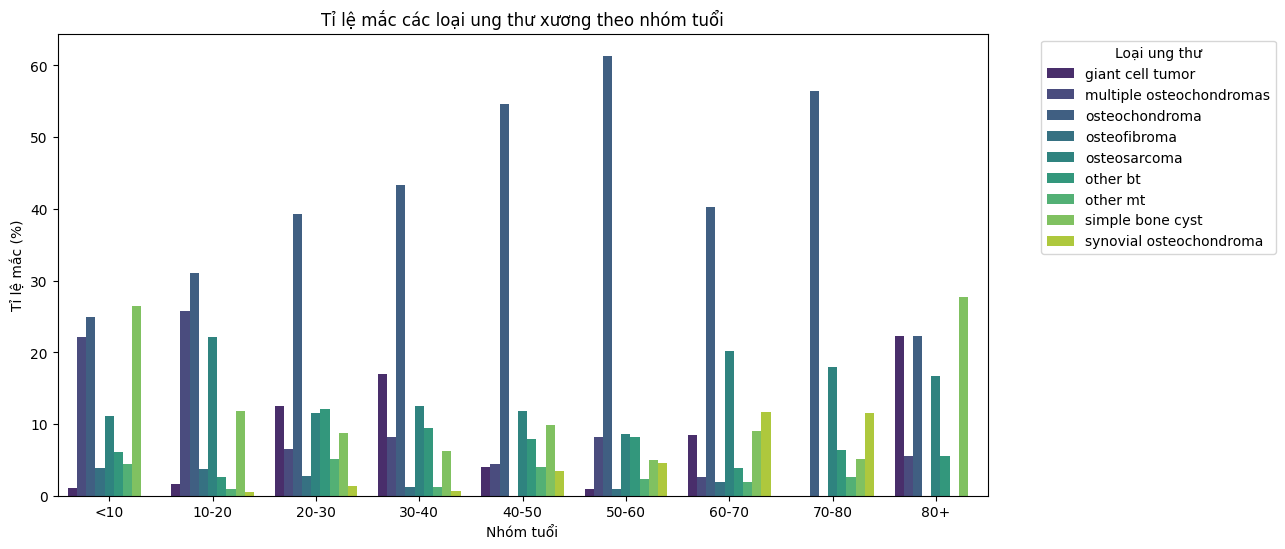

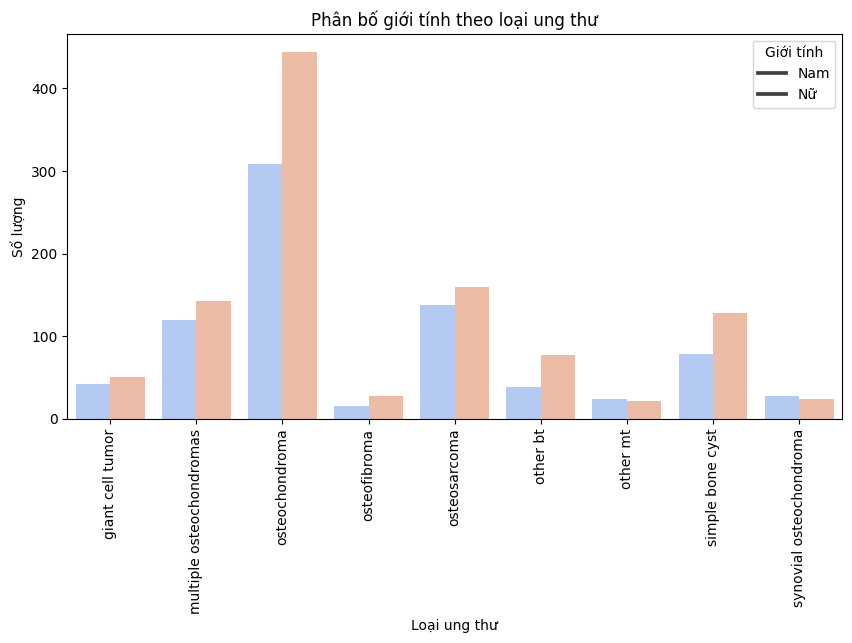

In [30]:
# Ngan
# tỉ lệ mắc các loại ung thư xương ở các độ tuổi và giới tính
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc file Excel
excel_path = '/kaggle/input/btxrd-data/BTXRD/BTXRD/dataset.xlsx'
df_info = pd.read_excel(excel_path, sheet_name=0)  # Sheet 1

# Đọc tất cả các file JSON trong thư mục chứa annotation
annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'
data_list = []

for json_file in os.listdir(annotation_dir):
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, "r") as f:
        data = json.load(f)
        image_id = data["imagePath"]
        # Lấy danh sách các nhãn ung thư từ shapes
        labels = [shape["label"] for shape in data["shapes"]]
        for label in set(labels):  # Loại bỏ trùng lặp nhãn trong cùng một ảnh
            data_list.append({"image_id": image_id, "cancer_type": label})

# Tạo DataFrame từ JSON
df_cancer = pd.DataFrame(data_list)

# Gộp dữ liệu từ dataset.xlsx với JSON theo `image_id`
df_merged = df_info.merge(df_cancer, on="image_id", how="inner")

# Chia nhóm tuổi (buckets)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ["<10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
df_merged["age_group"] = pd.cut(df_merged["age"], bins=bins, labels=labels, right=False)

# Tính tỉ lệ mắc ung thư theo từng nhóm tuổi
df_age_cancer = df_merged.groupby(["age_group", "cancer_type"]).size().reset_index(name="count")

# Chuẩn hóa tỉ lệ theo tổng số bệnh nhân trong từng nhóm tuổi
df_total_age = df_merged.groupby("age_group").size().reset_index(name="total_count")
df_age_cancer = df_age_cancer.merge(df_total_age, on="age_group")
df_age_cancer["ratio"] = df_age_cancer["count"] / df_age_cancer["total_count"] * 100  # Tính tỉ lệ %

# Vẽ biểu đồ tỉ lệ mắc ung thư theo nhóm tuổi
plt.figure(figsize=(12, 6))
sns.barplot(x="age_group", y="ratio", hue="cancer_type", data=df_age_cancer, palette="viridis")
plt.xlabel("Nhóm tuổi")
plt.ylabel("Tỉ lệ mắc (%)")
plt.title("Tỉ lệ mắc các loại ung thư xương theo nhóm tuổi")
plt.legend(title="Loại ung thư", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Biểu đồ 2: Phân bố giới tính theo loại ung thư (GIỮ NGUYÊN)
df_gender_count = df_merged.groupby(["cancer_type", "gender"]).size().reset_index(name="count")

plt.figure(figsize=(10, 5))
sns.barplot(x="cancer_type", y="count", hue="gender", data=df_gender_count, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Loại ung thư")
plt.ylabel("Số lượng")
plt.title("Phân bố giới tính theo loại ung thư")
plt.legend(title="Giới tính", labels=["Nam", "Nữ"])
plt.show()



Đang xử lý JSON: 100%|██████████| 1867/1867 [00:01<00:00, 1331.65file/s]


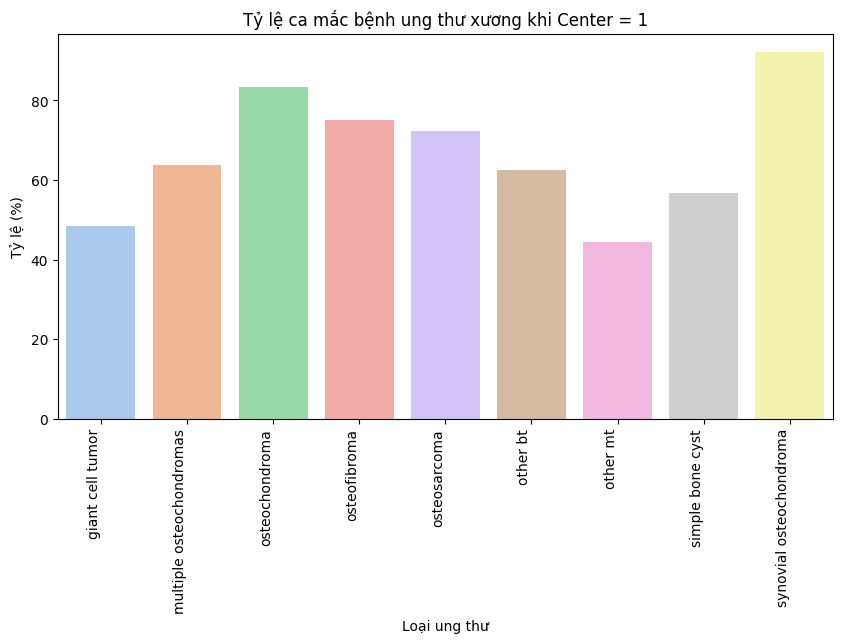

In [33]:
# Ngan
# tỉ lệ center = 1 vs các loại ung thư
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Hiển thị tiến trình

# Đọc file Excel
excel_path = '/kaggle/input/btxrd-data/BTXRD/BTXRD/dataset.xlsx'
df_info = pd.read_excel(excel_path, sheet_name=0)  # Đọc Sheet 1

# Đọc tất cả các file JSON trong thư mục chứa annotation
annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'
data_list = []

for json_file in tqdm(os.listdir(annotation_dir), desc="Đang xử lý JSON", unit="file"):
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        image_id = data["imagePath"]
        # Lấy danh sách các nhãn ung thư từ shapes
        labels = [shape["label"] for shape in data["shapes"]]
        for label in set(labels):  # Loại bỏ trùng lặp nhãn trong cùng một ảnh
            data_list.append({"image_id": image_id, "cancer_type": label})

# Tạo DataFrame từ JSON
df_json = pd.DataFrame(data_list)

# Gộp dữ liệu từ dataset.xlsx với JSON theo `image_id`
df_merged = pd.merge(df_info, df_json, on="image_id", how="inner")

# Tính tổng số ca mắc từng loại ung thư
df_total = df_merged.groupby("cancer_type").size().reset_index(name="total_count")

# Tính số ca mắc của `center = 1`
df_center_1 = df_merged[df_merged["center"] == 1].groupby("cancer_type").size().reset_index(name="center_1_count")

# Gộp lại để tính tỷ lệ
df_ratio = pd.merge(df_total, df_center_1, on="cancer_type", how="left").fillna(0)
df_ratio["percentage"] = (df_ratio["center_1_count"] / df_ratio["total_count"]) * 100

# Vẽ biểu đồ cột thể hiện tỷ lệ center = 1 với từng loại ung thư
plt.figure(figsize=(10, 5))
sns.barplot(x="cancer_type", y="percentage", data=df_ratio, palette="pastel")

# Thêm nhãn và tiêu đề
plt.xlabel("Loại ung thư")
plt.ylabel("Tỷ lệ (%)")
plt.title("Tỷ lệ ca mắc bệnh ung thư xương khi Center = 1")
plt.xticks(rotation=90, ha="right")

# Hiển thị biểu đồ
plt.show()


Đang xử lý JSON: 100%|██████████| 1867/1867 [00:01<00:00, 1327.60file/s]


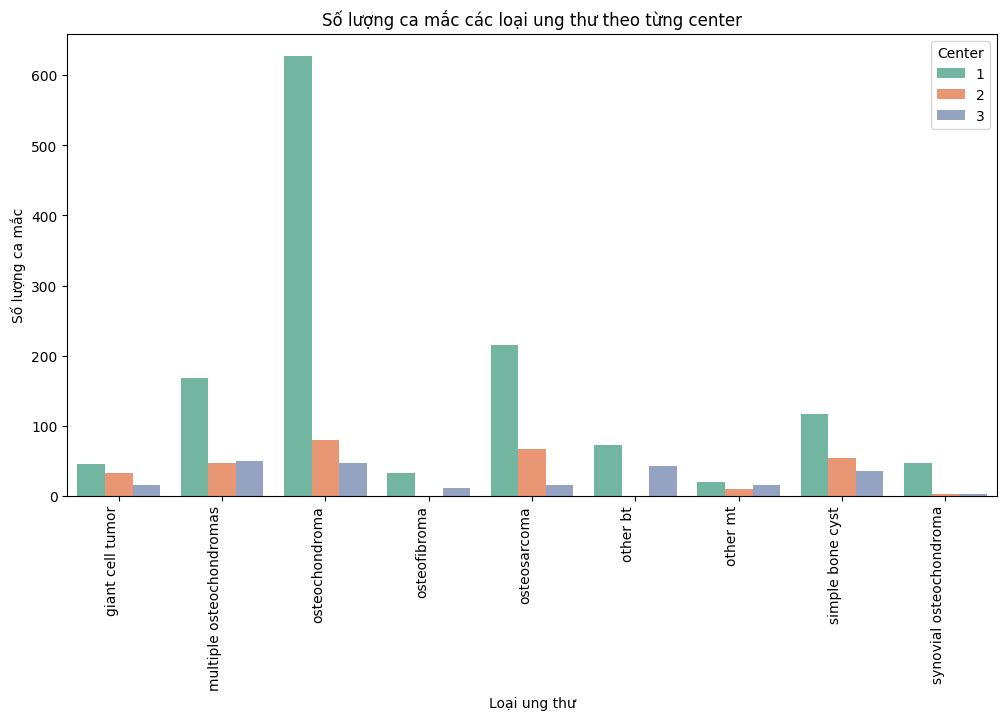

In [35]:
# Ngan
# Số lượng ca mắc các loại ung thư vs center
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Hiển thị tiến trình

# Đọc file Excel
excel_path = '/kaggle/input/btxrd-data/BTXRD/BTXRD/dataset.xlsx'
df_info = pd.read_excel(excel_path, sheet_name=0)  # Đọc Sheet 1

# Đọc tất cả các file JSON trong thư mục chứa annotation
annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'
data_list = []

for json_file in tqdm(os.listdir(annotation_dir), desc="Đang xử lý JSON", unit="file"):
    json_path = os.path.join(annotation_dir, json_file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        image_id = data["imagePath"]
        # Lấy danh sách các nhãn ung thư từ shapes
        labels = [shape["label"] for shape in data["shapes"]]
        for label in set(labels):  # Loại bỏ trùng lặp nhãn trong cùng một ảnh
            data_list.append({"image_id": image_id, "cancer_type": label})

# Tạo DataFrame từ JSON
df_json = pd.DataFrame(data_list)

# Gộp dữ liệu từ dataset.xlsx với JSON theo `image_id`
df_merged = pd.merge(df_info, df_json, on="image_id", how="inner")

# Nhóm dữ liệu theo loại ung thư và center
df_center_count = df_merged.groupby(["cancer_type", "center"]).size().reset_index(name="count")

# Vẽ biểu đồ cột thể hiện tỷ lệ mắc các loại ung thư theo center
plt.figure(figsize=(12, 6))
sns.barplot(x="cancer_type", y="count", hue="center", data=df_center_count, palette="Set2")

# Thêm nhãn và tiêu đề
plt.xlabel("Loại ung thư")
plt.ylabel("Số lượng ca mắc")
plt.title("Số lượng ca mắc các loại ung thư theo từng center")
plt.xticks(rotation=90, ha="right")
plt.legend(title="Center")

# Hiển thị biểu đồ
plt.show()


In [36]:
# Han
# tạo cột xác định tình trạng khối u 
def get_neoplasm(row):
    if row['tumor'] == 1:
        if row['benign'] == 1:
            return 'benign'
        if row['malignant'] == 1:
            return  'malignant'
    return 'no tumor'

df['neoplasm']=df.apply(get_neoplasm,axis=1)
df.to_excel("dataset_new.xlsx", index=False, engine="openpyxl")

# Hiển thị 5 dòng đầu tiên
print(df)

            image_id  center  age gender  hand  ulna  radius  humerus  foot  \
0     IMG000001.jpeg       1   48      F     0     0       0        0     0   
1     IMG000002.jpeg       1   12      M     0     0       0        0     0   
2     IMG000003.jpeg       1   12      M     0     0       0        0     0   
3     IMG000004.jpeg       1   52      M     0     0       0        0     1   
4     IMG000005.jpeg       1   52      M     0     0       0        0     1   
...              ...     ...  ...    ...   ...   ...     ...      ...   ...   
3741   IMG003742.jpg       3   55      M     0     0       0        0     0   
3742   IMG003743.jpg       3   55      M     0     0       0        0     0   
3743   IMG003744.jpg       3   55      M     0     0       0        0     0   
3744   IMG003745.jpg       3    8      M     0     0       0        0     0   
3745   IMG003746.jpg       3    8      M     0     0       0        0     0   

      tibia  ...  other bt  osteosarcoma  other mt 

# **Xử lý ảnh**

/kaggle/input/btxrd-data/BTXRD/BTXRD/images/IMG000005.jpeg


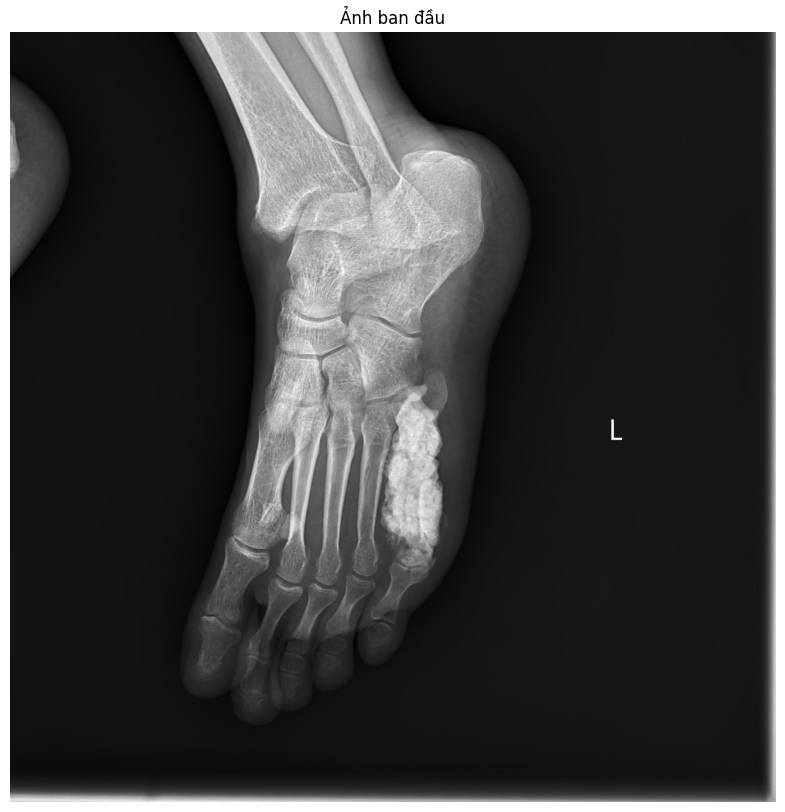

In [37]:
# Han
# hiển thị một ảnh ban đầu

with open(path+"Annotations/IMG000005.json", "r") as f:
    data = json.load(f)

# Lấy đường dẫn ảnh
image_path = path +'images/'+ data.get("imagePath", None)
print (image_path)
# Kiểm tra và đọc ảnh
if image_path and os.path.exists(image_path):  
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB để hiển thị đúng màu
else:
    print(f"⚠️ Không tìm thấy ảnh tại tạo nền trắng.")
    img = np.ones((data["imageHeight"], data["imageWidth"], 3), dtype=np.uint8) * 255  

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Ảnh ban đầu")
plt.axis("off")
plt.show()

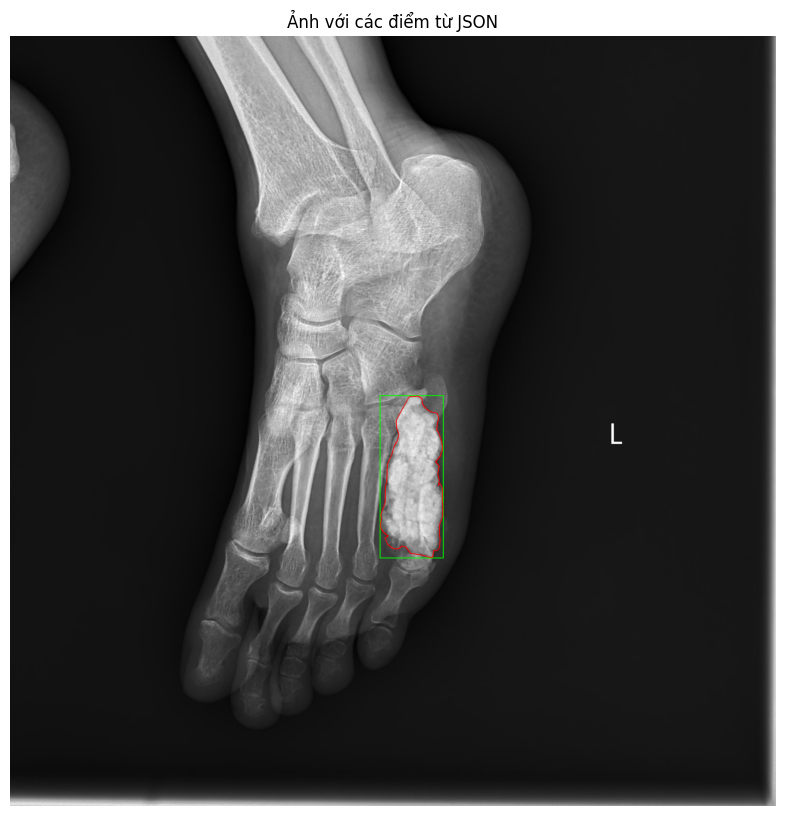

In [38]:
# Han
# Khoanh vùng khối u (bounding box)

# Vẽ các điểm từ JSON
for shape in data["shapes"]:
    points = np.array(shape["points"], dtype=np.int32)  # Chuyển về kiểu số nguyên
    label = shape["label"]
    
    # Kiểm tra loại hình dạng
    if shape["shape_type"] == "polygon":
        cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
    elif shape["shape_type"] == "rectangle":
        cv2.rectangle(img, tuple(points[0]), tuple(points[1]), (0, 255, 0), 2)

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Ảnh với các điểm từ JSON")
plt.axis("off")
plt.show()

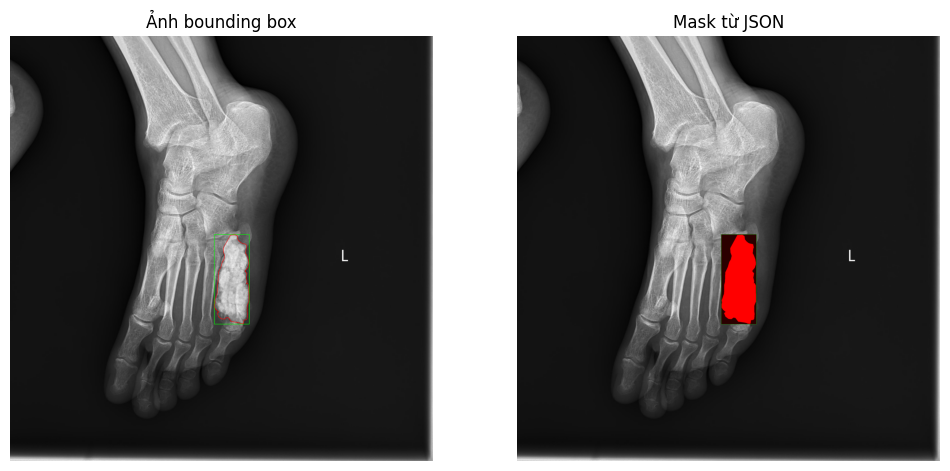

In [39]:
# Han
# tạo mask
# Tạo mask (ảnh đen) cùng kích thước với ảnh gốc
mask = img.copy()

# Duyệt qua các hình trong JSON và vẽ lên mask
for shape in data["shapes"]:
    points = np.array(shape["points"], dtype=np.int32)  # Chuyển về numpy array

    if shape["shape_type"] == "polygon":
        cv2.fillPoly(mask, [points], color=255)  # Đổ màu trắng vào mask
    elif shape["shape_type"] == "rectangle":
        cv2.rectangle(mask, tuple(points[0]), tuple(points[1]), 43, -1)  # -1 để tô kín

# Hiển thị ảnh gốc và mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Ảnh bounding box")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask từ JSON")
plt.axis("off")
plt.show()

In [41]:
# Han
# tính diện tích vùng ung thư
def get_point(data):
    polygons=[]
    for shape in data["shapes"]:
        if shape["shape_type"] == "polygon":
            polygons.append(np.array(shape["points"], dtype=np.int32))
    return polygons
    
def shoelace_area(data):
    n = len(data)
    area = 0
    for i in range(n):
        x1, y1 = points[i]
        x2, y2 = points[(i + 1) % n]  # Điểm kế tiếp (vòng lại điểm đầu)
        area += (x1 * y2 - x2 * y1)
    return abs(area) / 2

# Lấy danh sách polygons từ JSON
polygons = get_point(data)

# Tính diện tích cho từng polygon
areas_tumor = [shoelace_area(polygon) for polygon in polygons]

print("Diện tích vùng ung thư")
print(areas_tumor)
print("Diện tích ảnh")
print(data["imageHeight"]*data["imageWidth"])

Diện tích vùng ung thư
[88553.5]
Diện tích ảnh
7017152


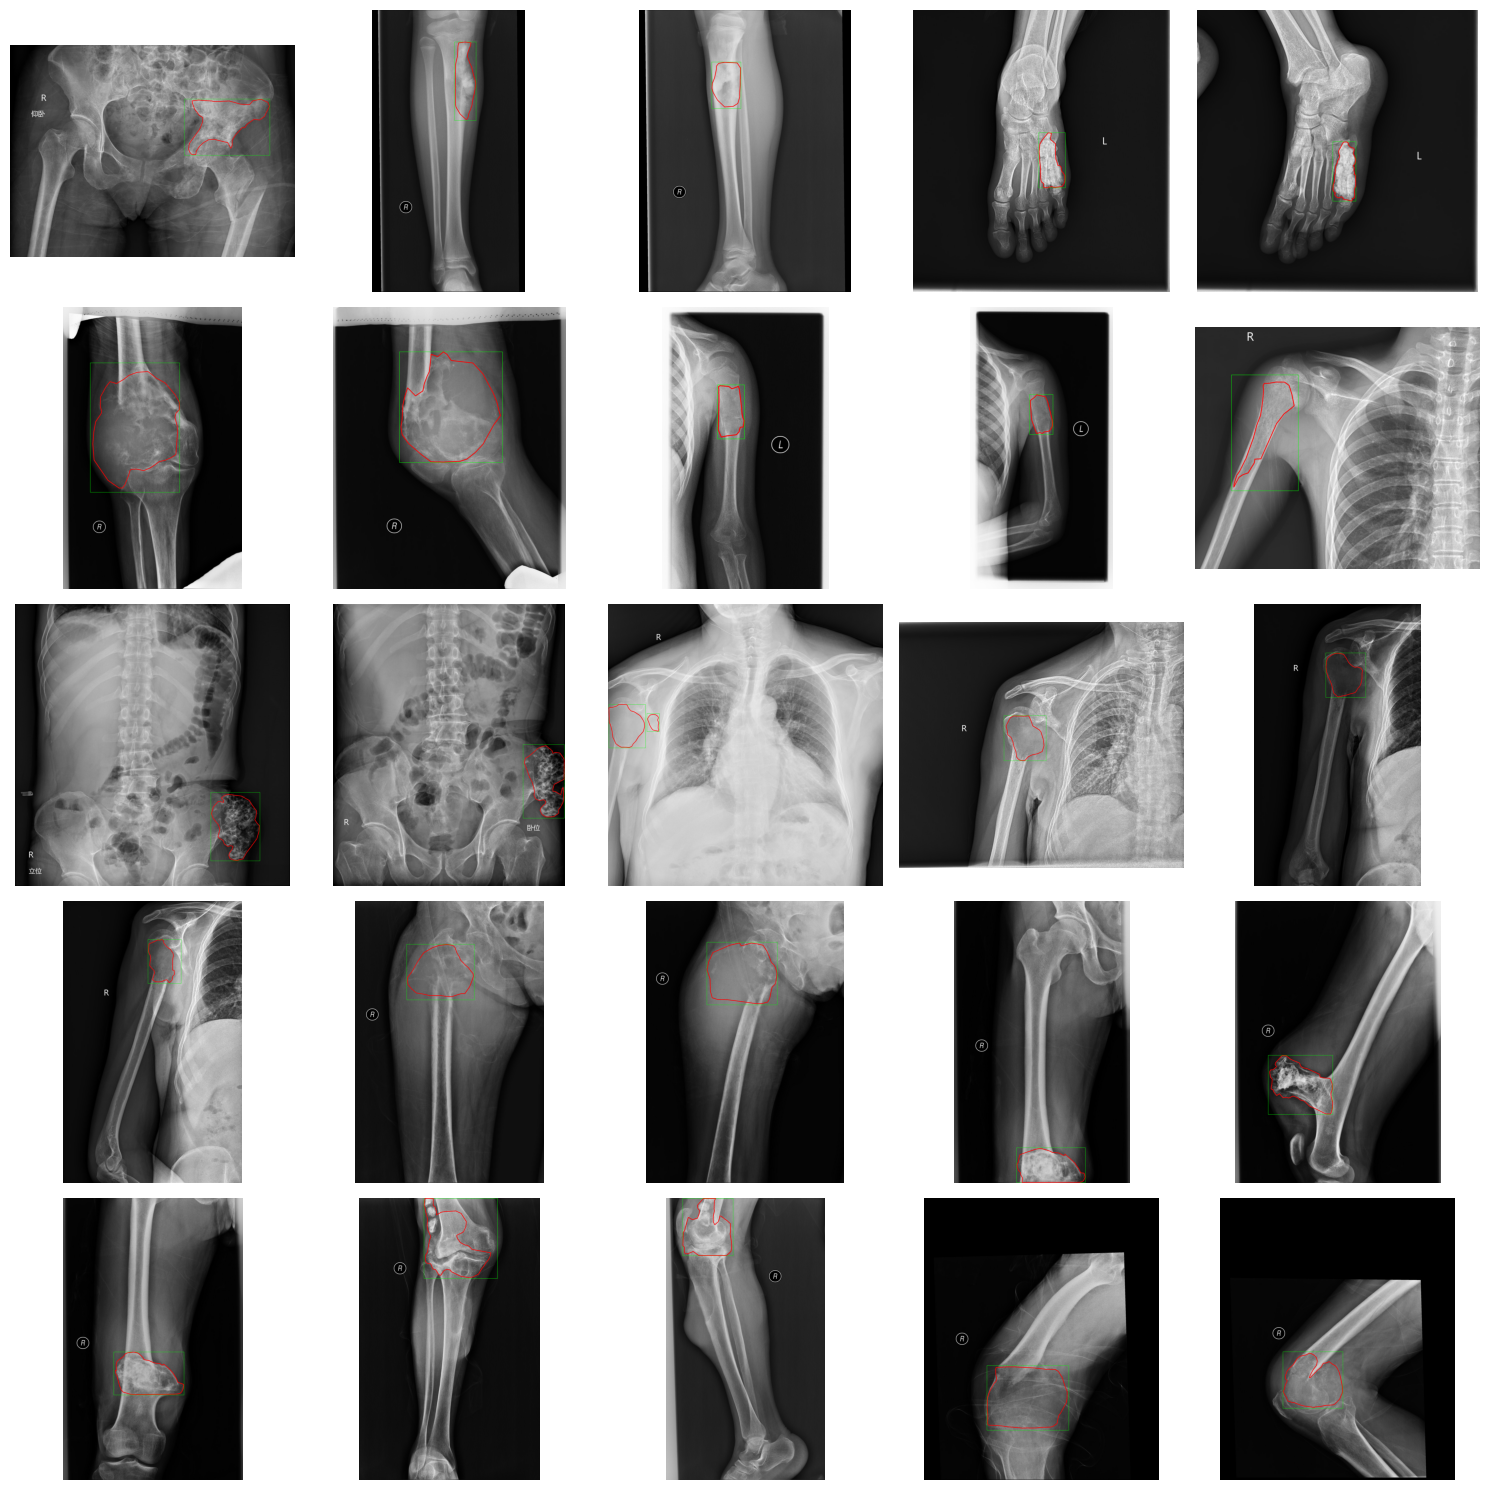

In [42]:
# Ngan 
# bounding box 25 ảnh 

# Lấy 25 file JSON đầu tiên từ thư mục
json_files = sorted(os.listdir(annotation_dir))[:25]

# Danh sách lưu ảnh đã vẽ bounding box
processed_images = []

for json_file in json_files:
    json_path = os.path.join(annotation_dir, json_file)
    
    with open(json_path, "r") as f:
        data = json.load(f)

    # Lấy đường dẫn ảnh
    image_path = os.path.join(image_dir, data["imagePath"])
    
    if not os.path.exists(image_path):
        continue  # Bỏ qua nếu ảnh không tồn tại
    
    # Đọc ảnh
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vẽ bounding box từ annotation
    for shape in data["shapes"]:
        points = np.array(shape["points"], dtype=np.int32)
        
        if shape["shape_type"] == "polygon":
            cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=5)
        elif shape["shape_type"] == "rectangle":
            cv2.rectangle(img, tuple(points[0]), tuple(points[1]), (0, 255, 0), 2)

    # Thêm ảnh đã xử lý vào danh sách
    processed_images.append(img)

# Hiển thị ảnh theo lưới 5x5
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(processed_images):
        ax.axis("off")
        continue
    ax.imshow(processed_images[i])
    ax.axis("off")  

plt.tight_layout()
plt.show()



**Từ đây trở xuống là nháp ↓↓↓↓↓↓**

In [ ]:
# Ngan
# mask 25 ảnh ở đầu

# Lấy 25 file JSON đầu tiên từ thư mục
json_files = sorted(os.listdir(annotation_dir))[:25]

# Danh sách lưu ảnh đã vẽ bounding box
processed_images = []

for json_file in json_files:
    json_path = os.path.join(annotation_dir, json_file)
    
    with open(json_path, "r") as f:
        data = json.load(f)

    # Lấy đường dẫn ảnh
    image_path = os.path.join(image_dir, data["imagePath"])
    
    if not os.path.exists(image_path):
        continue  # Bỏ qua nếu ảnh không tồn tại
    
    # Đọc ảnh
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vẽ bounding box từ annotation
    for shape in data["shapes"]:
        points = np.array(shape["points"], dtype=np.int32)
        
        if shape["shape_type"] == "polygon":
            cv2.fillPoly(mask, [points], color=(255, 0, 0))  # Đổ màu trắng vào mask
        elif shape["shape_type"] == "rectangle":
            cv2.rectangle(mask, tuple(points[0]), tuple(points[1]), 43, -1)  # -1 để tô kín
    
    # Thêm ảnh đã xử lý vào danh sách
    processed_images.append(img)

# Hiển thị ảnh theo lưới 5x5
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(processed_images):
        ax.axis("off")
        continue
    ax.imshow(processed_images[i])
    ax.axis("off")  

plt.tight_layout()
plt.show()



In [ ]:
# Ngan
# mask 25 ảnh ở trên

import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Đường dẫn dữ liệu
image_dir = "/kaggle/input/btxrd-data/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/Annotations"

# Chọn 25 file JSON ngẫu nhiên
json_files = random.sample(os.listdir(annotation_dir), 25)

# Danh sách lưu ảnh gốc và mask
processed_images = []
processed_masks = []

for json_file in json_files:
    json_path = os.path.join(annotation_dir, json_file)
    
    with open(json_path, "r") as f:
        data = json.load(f)

    # Lấy đường dẫn ảnh
    image_path = os.path.join(image_dir, data["imagePath"])
    
    if not os.path.exists(image_path):
        continue  # Bỏ qua nếu ảnh không tồn tại
    
    # Đọc ảnh gốc
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Tạo mask đen cùng kích thước ảnh
    height, width = data["imageHeight"], data["imageWidth"]
    mask = np.zeros((height, width), dtype=np.uint8)

    # Vẽ bounding box lên ảnh gốc và mask
    for shape in data["shapes"]:
        points = np.array(shape["points"], dtype=np.int32)
        
        # Vẽ trên ảnh gốc
        if shape["shape_type"] == "polygon":
            cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
            cv2.fillPoly(mask, [points], color=255)  # Vẽ lên mask
        elif shape["shape_type"] == "rectangle":
            cv2.rectangle(img, tuple(points[0]), tuple(points[1]), (0, 255, 0), 2)
            cv2.rectangle(mask, tuple(points[0]), tuple(points[1]), 255, -1)  # Vẽ lên mask

    # Thêm ảnh gốc và mask vào danh sách
    processed_images.append(img)
    processed_masks.append(mask)

# Hiển thị ảnh gốc và mask theo lưới 5x5
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols * 2, figsize=(15, 15))  # Gấp đôi số cột để hiển thị ảnh và mask

for i, ax in enumerate(axes.flat):
    if i >= len(processed_images) * 2:
        ax.axis("off")
        continue
    if i % 2 == 0:
        ax.imshow(processed_images[i // 2])  # Ảnh gốc
        ax.set_title("Ảnh gốc")
    else:
        ax.imshow(processed_masks[i // 2], cmap="gray")  # Mask
        ax.set_title("Mask từ JSON")
    ax.axis("off")  

plt.tight_layout()
plt.show()


In [ ]:
# Ngan
# Phân tích đặc điểm hình ảnh
image_shapes = []

for image_file in image_files[:20]:  # Phân tích 20 hình ảnh đầu
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_shapes.append(image.size)

# Tạo DataFrame chứa kích thước hình ảnh
shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(shape_df.describe())

# Vẽ biểu đồ phân bố kích thước hình ảnh
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Width', y='Height', data=shape_df)
plt.title('Phân bố kích thước hình ảnh')
plt.xlabel('Chiều rộng (px)')
plt.ylabel('Chiều cao (px)')
plt.show()


# **Tiền xử lý dữ liệu**

In [ ]:
# Ngan
import numpy as np

# Hàm đọc và tiền xử lý hình ảnh
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Chuẩn hóa pixel từ 0-255 về 0-1
    return np.expand_dims(img, axis=-1)

# Hàm tạo mask từ file JSON
def create_mask_from_json(json_path, img_shape=(224, 224)):
    mask = np.zeros(img_shape, dtype=np.uint8)
    with open(json_path, 'r') as f:
        data = json.load(f)
        for shape in data['shapes']:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], 255)
    return mask

# Kiểm tra hình ảnh và mask tương ứng
image_path = os.path.join(image_dir, image_files[0])
json_path = os.path.join(annotation_dir, json_files[0])

img = load_and_preprocess_image(image_path)
mask = create_mask_from_json(json_path)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Hình ảnh X-quang')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask Khối U')
plt.show()


# **Tiền xử lý dữ liệu (2)**

In [ ]:
# Ngan
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Kiểm tra nếu labels đã là One-Hot Encoding hay chưa
if labels.ndim > 1 and labels.shape[1] > 1:
    print("Labels đã ở dạng One-Hot Encoding, bỏ qua LabelEncoder.")
else:
    print("Labels ở dạng chuỗi hoặc chỉ số, tiến hành mã hóa.")
    # Mã hóa nhãn (Label Encoding) và sau đó One-Hot Encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Chuyển về mảng 1D
    labels = to_categorical(labels)  # Chuyển sang One-Hot Encoding

# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Tập huấn luyện: {X_train.shape}, Tập kiểm tra: {X_test.shape}')


In [ ]:
# Ngan
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Đọc dữ liệu và tiền xử lý
image_dir = '/kaggle/input/btxrd-data/BTXRD/'
labels = []
images = []

# Đọc tất cả các ảnh và nhãn từ thư mục
for label_folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))  # Resize ảnh về cùng kích thước
        images.append(image)
        labels.append(label_folder)  # Lấy tên thư mục làm nhãn

# Chuyển đổi dữ liệu về numpy array
images = np.array(images) / 255.0  # Chuẩn hóa pixel [0, 1]
labels = np.array(labels)

# Mã hóa nhãn và One-Hot Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Mã hóa nhãn thành số
labels = to_categorical(labels)  # One-hot encoding

# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Tập huấn luyện: {X_train.shape}, Tập kiểm tra: {X_test.shape}')

# 2. Xây dựng mô hình CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 lớp đầu ra: "Normal" và "Tumor"
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 3. Huấn luyện mô hình
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# 4. Đánh giá mô hình
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Độ chính xác trên tập kiểm tra: {test_accuracy * 100:.2f}%')

# 5. Dự đoán với ảnh mới
def predict_image(image_path, model, label_encoder):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    confidence_score = np.max(prediction) * 100

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Dự đoán: {predicted_label[0]} ({confidence_score:.2f}%)')
    plt.axis('off')
    plt.show()

# Ví dụ dự đoán một ảnh mới
predict_image('/kaggle/input/btxrd-data/BTXRD/images/IMG000001.jpeg', model, label_encoder)


# **Xây dựng mô hình**

In [ ]:
# Ngan
from tensorflow.keras import layers, models

def build_unet_model(input_shape=(224, 224, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Attention cơ bản (ví dụ minh họa)
    attention = layers.Conv2D(32, (1, 1), activation='sigmoid')(p1)
    p1 = layers.multiply([p1, attention])

    # Decoder
    u1 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(p1)
    u1 = layers.concatenate([u1, c1])
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_unet_model()
model.summary()


# **Đánh giá mô hình**

In [ ]:
# Ngan
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Giả sử y_true và y_pred là nhãn thực tế và dự đoán
y_true = [0, 1, 0, 1, 1]  # ví dụ
y_pred = [0, 1, 0, 0, 1]  # ví dụ

print(classification_report(y_true, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()
